# Georgetown  MSBA
## Final Project - Fall 2024
Saxa 3
Mike Johnson | Kesh Kamani | Ryan Mathis | Khushi Patel | Andrew Singh

### Prep

In [83]:
#Install tidyverse

library(tidyverse)

# Load data
listings = read.csv("Listings.csv")
reviews = read.csv("Reviews.csv")

In [84]:
# Join reviews to listings into a new data frame
df = left_join(listings,
               reviews,
               by = join_by(id == listing_id))

### Data Cleaning

In [85]:
# Review data types
str(df)

'data.frame':	1718 obs. of  15 variables:
 $ id                  : int  4 6 9 11 14 15 16 17 19 20 ...
 $ neighborhood        : chr  "Union Station" "Shaw" "Dupont Circle" "Shaw" ...
 $ host_since          : chr  "5/2/2010" "10/31/2009" "6/20/2011" "10/31/2009" ...
 $ superhost           : logi  FALSE FALSE FALSE FALSE TRUE FALSE ...
 $ host_acceptance_rate: num  NA 0.91 0 0.91 0.86 1 0.46 NA 0.73 0.98 ...
 $ host_total_listings : int  4 8 1 8 1 1 12 6 4 3 ...
 $ room_type           : chr  "Entire home/apt" "Entire home/apt" "Entire home/apt" "Entire home/apt" ...
 $ accommodates        : int  4 4 2 4 2 4 4 3 3 4 ...
 $ bathrooms           : chr  "1 bath" "1 bath" "1 bath" "1 bath" ...
 $ bedrooms            : int  1 2 1 2 1 1 2 2 1 1 ...
 $ beds                : int  3 3 1 2 1 3 3 2 1 2 ...
 $ price               : int  645 80 135 80 185 149 198 129 184 200 ...
 $ min_nights          : int  31 31 31 31 2 3 5 90 2 3 ...
 $ total_reviews       : int  15 196 31 188 164 70 19 1 152 268 ..

In [86]:
# Change incorrect data types
df$host_since = as.Date(df$host_since, format = "%m/%d/%Y")
df$bathrooms = as.numeric(sub(" .*", "", df$bathrooms))

In [87]:
head(df, 10)

,id,neighborhood,host_since,superhost,host_acceptance_rate,host_total_listings,room_type,accommodates,bathrooms,bedrooms,beds,price,min_nights,total_reviews,avg_rating
,<int>,<chr>,<date>,<lgl>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,4,Union Station,2010-05-02,FALSE,NA,4,Entire home/apt,4,1,1,3,645,31,15,4.77
2,6,Shaw,2009-10-31,FALSE,0.91,8,Entire home/apt,4,1,2,3,80,31,196,4.35
3,9,Dupont Circle,2011-06-20,FALSE,0.00,1,Entire home/apt,2,1,1,1,135,31,31,4.83
4,11,Shaw,2009-10-31,FALSE,0.91,8,Entire home/apt,4,1,2,2,80,31,188,4.30
5,14,Shaw,2011-12-14,TRUE,0.86,1,Entire home/apt,2,1,1,1,185,2,164,4.84
6,15,Dupont Circle,2011-12-22,FALSE,1.00,1,Entire home/apt,4,1,1,3,149,3,70,4.89
7,16,Dupont Circle,2011-07-01,FALSE,0.46,12,Entire home/apt,4,1,2,3,198,5,19,4.56
8,17,Union Station,2012-01-25,FALSE,NA,6,Entire home/apt,3,2,2,2,129,90,1,4.00
9,19,Capitol Hill,2011-09-01,TRUE,0.73,4,Entire home/apt,3,1,1,1,184,2,152,4.78


#### NA Handling

In [88]:
# Identify columns with NA's
apply(df, 2, anyNA)

id         neighborhood           host_since 
               FALSE                FALSE                FALSE 
           superhost host_acceptance_rate  host_total_listings 
               FALSE                 TRUE                FALSE 
           room_type         accommodates            bathrooms 
                TRUE                FALSE                FALSE 
            bedrooms                 beds                price 
                TRUE                FALSE                FALSE 
          min_nights        total_reviews           avg_rating 
               FALSE                FALSE                 TRUE

##### host_acceptance_rate

In [89]:
# Replace NA's in $host_acceptance_rate with mean
missing_host_acceptance_rate = which(is.na(df$host_acceptance_rate))
df$host_acceptance_rate[missing_host_acceptance_rate] = mean(df$host_acceptance_rate, na.rm = TRUE)

##### room_type

In [90]:
# Identify the most common room type
most_common_room_type =
  df %>%
  group_by(room_type) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  slice(1) %>%
  pull(room_type)

most_common_room_type

[1] "Entire home/apt"

In [91]:
# Replace NA's with most common room type
df =
  df %>%
  mutate(room_type = if_else(is.na(room_type), most_common_room_type,room_type))

##### bedrooms

In [92]:
# Can we predict the number of bedrooms based on number of beds?

# Create linear model between $beds and $bedrooms
bedrooms_reg = lm(bedrooms~beds, df, na.action = na.exclude)
summary(bedrooms_reg) # r-squared = 0.60. Suggesting a moderately strong relationship.


Call:
lm(formula = bedrooms ~ beds, data = df, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.31105 -0.52177  0.07465  0.28537  2.28537 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.32892    0.03141   10.47   <2e-16 ***
beds         0.59643    0.01286   46.38   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5609 on 1455 degrees of freedom
  (261 observations deleted due to missingness)
Multiple R-squared:  0.5965,	Adjusted R-squared:  0.5962 
F-statistic:  2151 on 1 and 1455 DF,  p-value: < 2.2e-16


In [93]:
# Predict values for all rows
df$predicted_bedrooms = predict(bedrooms_reg, df)

# Round the predicted values. Can't have partial bedrooms.
df$predicted_bedrooms = round(df$predicted_bedrooms)

# Replace NA Values in $bedrooms with the predictions
df =
  df %>%
  mutate(bedrooms = if_else(is.na(bedrooms), predicted_bedrooms, bedrooms)) %>%
  select(!predicted_bedrooms)

# Set $bedrooms to integer
df$bedrooms = as.integer(df$bedrooms)

##### avg_rating

In [94]:
## Replace NA'S in $avg_rating with mean. ##
missing_avg_rating = which(is.na(df$avg_rating))
df$avg_rating[missing_avg_rating] = mean(df$avg_rating, na.rm = TRUE)

#### Confirm that there are no NA's

In [95]:
apply(df, 2, anyNA)

id         neighborhood           host_since 
               FALSE                FALSE                FALSE 
           superhost host_acceptance_rate  host_total_listings 
               FALSE                FALSE                FALSE 
           room_type         accommodates            bathrooms 
               FALSE                FALSE                FALSE 
            bedrooms                 beds                price 
               FALSE                FALSE                FALSE 
          min_nights        total_reviews           avg_rating 
               FALSE                FALSE                FALSE

In [96]:
head(df, 10)

,id,neighborhood,host_since,superhost,host_acceptance_rate,host_total_listings,room_type,accommodates,bathrooms,bedrooms,beds,price,min_nights,total_reviews,avg_rating
,<int>,<chr>,<date>,<lgl>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,4,Union Station,2010-05-02,FALSE,0.9394853,4,Entire home/apt,4,1,1,3,645,31,15,4.77
2,6,Shaw,2009-10-31,FALSE,0.9100000,8,Entire home/apt,4,1,2,3,80,31,196,4.35
3,9,Dupont Circle,2011-06-20,FALSE,0.0000000,1,Entire home/apt,2,1,1,1,135,31,31,4.83
4,11,Shaw,2009-10-31,FALSE,0.9100000,8,Entire home/apt,4,1,2,2,80,31,188,4.30
5,14,Shaw,2011-12-14,TRUE,0.8600000,1,Entire home/apt,2,1,1,1,185,2,164,4.84
6,15,Dupont Circle,2011-12-22,FALSE,1.0000000,1,Entire home/apt,4,1,1,3,149,3,70,4.89
7,16,Dupont Circle,2011-07-01,FALSE,0.4600000,12,Entire home/apt,4,1,2,3,198,5,19,4.56
8,17,Union Station,2012-01-25,FALSE,0.9394853,6,Entire home/apt,3,2,2,2,129,90,1,4.00
9,19,Capitol Hill,2011-09-01,TRUE,0.7300000,4,Entire home/apt,3,1,1,1,184,2,152,4.78


## Analysis

### 1) Report your exploratory analysis of the data. This can include data visualization, summary tables, changes made to the data, or any other insightful findings about the data.

In [97]:
## Check popularity of neighborhood based on number of reviews per listing (assumes more reviews = more people who will rent), checks room type seperately##
df %>%
  group_by(neighborhood) %>%
  filter(room_type=="Entire home/apt") %>%
  summarize(
    StayCount = sum(total_reviews, na.rm = TRUE),  # Sum of reviews
    PriceperPerson = round(sum(price)/sum(accommodates), 2),  # Average price per person
    ListingCount = length(neighborhood),  # Count of listings
    StaysperListing = round(StayCount/ListingCount)) %>% #ratio of reviews per listing
  arrange(desc(StaysperListing))


df %>%
  group_by(neighborhood) %>%
  filter(room_type=="Private room") %>%
  summarize(
    StayCount = sum(total_reviews, na.rm = TRUE),  # Sum of reviews
    PriceperPerson = round(sum(price)/sum(accommodates), 2),  # Average price per person
    ListingCount = length(neighborhood),  # Count of listings
    StaysperListing = round(StayCount/ListingCount)) %>% #ratio of reviews per listing
  arrange(desc(StaysperListing))

neighborhood,StayCount,PriceperPerson,ListingCount,StaysperListing
<chr>,<int>,<dbl>,<int>,<dbl>
Georgetown,11929,58.71,126,95
Capitol Hill,35978,49.60,397,91
Shaw,20043,55.37,231,87
Union Station,38644,47.74,475,81
Dupont Circle,19138,57.24,288,66
Foggy Bottom,6034,56.52,91,66


neighborhood,StayCount,PriceperPerson,ListingCount,StaysperListing
<chr>,<int>,<dbl>,<int>,<dbl>
Dupont Circle,2327,112.95,17,137
Union Station,700,70.62,12,58
Foggy Bottom,233,92.78,5,47
Shaw,1301,42.38,41,32
Capitol Hill,34,27.83,2,17
Georgetown,92,63.85,12,8


### 2) Which combination of neighborhood and room type has the highest average price? Which one has the lowest? Which combination has the highest variability? Which combination has the lowest?

In [98]:

##Summarize data by Avg Price per room type in each neighborhood##
df %>%
  group_by(neighborhood, room_type) %>%
  summarize(TotalUnits = length(room_type),
            AvgPrice = round(mean(price), 2),
            AvgPriceperPerson = round(sum(price)/sum(accommodates), 2)) %>%
  arrange(desc(AvgPrice))


##Use IQR method to check for variability in price by room type in each neighborhood. Disregards Shared Rooms since these are only present in two neighborhoods. ##
df %>%
  group_by(neighborhood, room_type) %>%
  filter(room_type != "Shared room") %>%
  summarize(IQR = IQR(price, na.rm= TRUE)) %>%
  arrange(IQR)

`summarise()` has grouped output by 'neighborhood'. You can override using the
`.groups` argument.


neighborhood,room_type,TotalUnits,AvgPrice,AvgPriceperPerson
<chr>,<chr>,<int>,<dbl>,<dbl>
Foggy Bottom,Private room,5,334.00,92.78
Georgetown,Entire home/apt,126,253.03,58.71
Dupont Circle,Private room,17,245.82,112.95
Shaw,Entire home/apt,231,237.28,55.37
Union Station,Entire home/apt,475,206.42,47.74
Union Station,Private room,12,200.08,70.62
Capitol Hill,Entire home/apt,397,198.01,49.60
Dupont Circle,Entire home/apt,288,189.62,57.24
Foggy Bottom,Entire home/apt,91,172.05,56.52


`summarise()` has grouped output by 'neighborhood'. You can override using the
`.groups` argument.


neighborhood,room_type,IQR
<chr>,<chr>,<dbl>
Shaw,Private room,0.00
Foggy Bottom,Private room,20.00
Capitol Hill,Private room,23.50
Georgetown,Private room,35.00
Foggy Bottom,Entire home/apt,84.00
Union Station,Private room,93.00
Capitol Hill,Entire home/apt,101.00
Dupont Circle,Entire home/apt,101.00
Dupont Circle,Private room,119.00


### 3) Write an R function that takes three arguments: a confidence level, the name of a numerical variable, and a data frame. The function should return the confidence interval for the average value of the specified variable at the given confidence level. Apply this function to compute a 95% confidence interval for the average price of the listings in the dataset. Provide an interpretation of the computed confidence interval in the context of the Airbnb listings.

In [99]:
# Define the function
confidence_interval <- function(conf_level, variable_name, data_frame) {

# Extract the specific variable as a vector from the data frame
variable <- data_frame[[variable_name]]

# Perform the t-test to calculate confidence interval
t_test_result <- t.test(variable, conf.level = conf_level)

# Extract the confidence interval from the t-test result
lower_bound <- t_test_result$conf.int[1]
upper_bound <- t_test_result$conf.int[2]

# Return the confidence interval
return(c(lower_bound, upper_bound))
}

# Compute the 95% confidence interval for the average price
ci_95 <- confidence_interval(0.95, 'price', df)

# Display the result
print(paste("The 95% confidence interval for the average price is:", round(ci_95[1], 2), "to", round(ci_95[2],2)))

[1] "The 95% confidence interval for the average price is: 198.35 to 211.34"


### 4) Test whether the average price of all listings in the population is more than $200 (at 95% level of confidence). What is the statistical conclusion based on this result? Is this conclusion in line with the estimated confidence interval reported in question 3?

Null Hypothesis: mu = 200

Alternative Hypothesis: mu > 200

In [100]:
# Perform a one-sample t-test comparing the sample mean to 200
t_test_result <- t.test(df$price, mu = 200, alternative ="greater")

# Extract the t-statistic and p-value
t_stat <- t_test_result$statistic
p_value <- t_test_result$p.value

# Print the results
cat("t-statistic:", t_stat, "\n")
cat("p-value:", p_value, "\n")

# Interpret the results
if (p_value < 0.05) { cat("At 0.05 significance, we reject the null hypothesis that the average price is less than or equal to $200.\n") } else { cat("At 0.05 significance, we fail to reject the null hypothesis. The average price is not significantly greater than $200.\n") }

t-statistic: 1.462282 
p-value: 0.07192354 
At 0.05 significance, we fail to reject the null hypothesis. The average price is not significantly greater than $200.


### 5) Visualize price to test for normality and comment on the results (diagnostics plots generated for this question will be counted as only 1 plot in your report - see below for details).

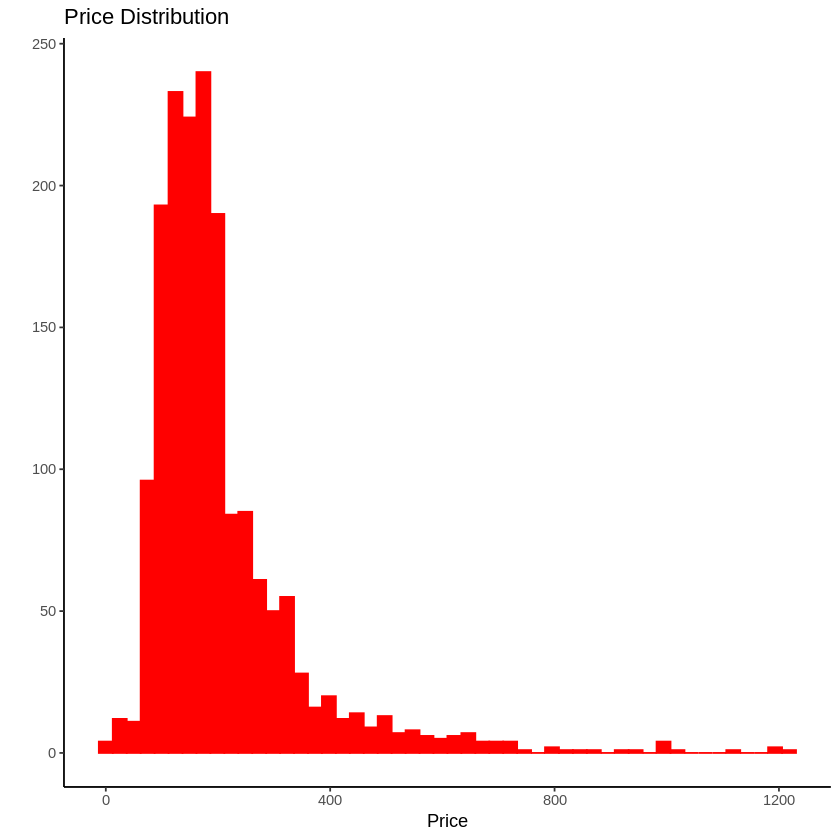

In [101]:
# Visual to test normality
df %>%
  ggplot(aes(price)) + # Dimensions
  geom_histogram(color = "red",
                 fill = "red",
                 bins = 50) + # Viz
  theme_classic() + # Set Theme
  # Set Labels
  labs(x = "Price",
       y = "",
       title = "Price Distribution")

In [102]:
# Percentiles
quantile(df$price, .25)
quantile(df$price, .5)
quantile(df$price, .75)

25% 
125

50% 
171

75% 
237

Data is skewed right, with most prices falling between $0-$400 roughly. There are fewer properties with prices >$400.

### 6) What’s the best simple linear regression model for “price” of the listings based on R-squared and residual standard error? Compare/present the results of the tested models as a table in your report. (Note: You should not manually create the comparison table in your submitted report. Your code should generate the table.)

In [103]:
# Create regression models
neighborhood_reg = lm(price~neighborhood, df)
host_since_reg = lm(price~host_since, df)
superhost_reg = lm(price~superhost, df)
host_acceptance_rate_reg = lm(price~host_acceptance_rate, df)
host_total_listings_reg = lm(price~host_total_listings, df)
room_type_reg = lm(price~room_type, df)
accommodates_reg = lm(price~accommodates, df)
bathrooms_reg = lm(price~bathrooms, df)
bedrooms_reg = lm(price~bedrooms, df)
beds_reg = lm(price~beds, df)
min_nights_reg = lm(price~min_nights, df)
total_reviews_reg = lm(price~total_reviews, df)
avg_rating_reg = lm(price~avg_rating, df)

#### Summary Table Creation

In [104]:
# Create data frame with regression model names and objects

# List of models
models = list(neighborhood_reg,
              host_since_reg,
              superhost_reg,
              host_acceptance_rate_reg,
              host_total_listings_reg,
              room_type_reg,
              accommodates_reg,
              bathrooms_reg,
              bedrooms_reg,
              beds_reg,
              min_nights_reg,
              total_reviews_reg,
              avg_rating_reg)

# Model names
model_names = c("Neighborhood",
                "Host Since",
                "Superhost",
                "Host Acceptance Rate",
                "Host Total Listings",
                 "Room Type",
                "Accommodates",
                "Bathrooms",
                "Bedrooms",
                "Beds",
                "Min Nights",
                "Total Reviews",
                "Avg Rating")

# Create a data frame with model names and models
model_df = data.frame(Model = model_names, Model_Object = I(models))

In [105]:
# Functions to grab r-squared and residual standard error
get_model_rsquare = function(model) {round(summary(model)$r.squared, 2)}
get_model_sigma = function(model) {round(summary(model)$sigma, 2)}

In [106]:
# Apply functions model_df
model_summary =
  model_df %>%
  mutate(`R-Squared` = sapply(Model_Object, get_model_rsquare),
         `RSE` = sapply(Model_Object, get_model_sigma))

#### Summary Table

In [107]:
# Table summarizing R-Squared and RSE
model_summary %>%
  select(!Model_Object) %>%
  arrange(desc(`R-Squared`))

Model,R-Squared,RSE
<chr>,<dbl>,<dbl>
Bathrooms,0.38,107.99
Accommodates,0.34,111.15
Bedrooms,0.34,111.71
Beds,0.27,117.36
Neighborhood,0.01,136.49
Superhost,0.01,136.60
Host Acceptance Rate,0.01,136.89
Room Type,0.01,136.39
Min Nights,0.01,136.69


The best simple regression model for 'Price' is 'Bathrooms'. This is because the model has highest R-squared value at 0.38 and lowest residual standard error. A higher R-squared means that the model does a better job at explaining variability in price compared to the other models tested. A lower residual standard error means that the model makes predictions that are closer to actual values.

`geom_smooth()` using formula = 'y ~ x'


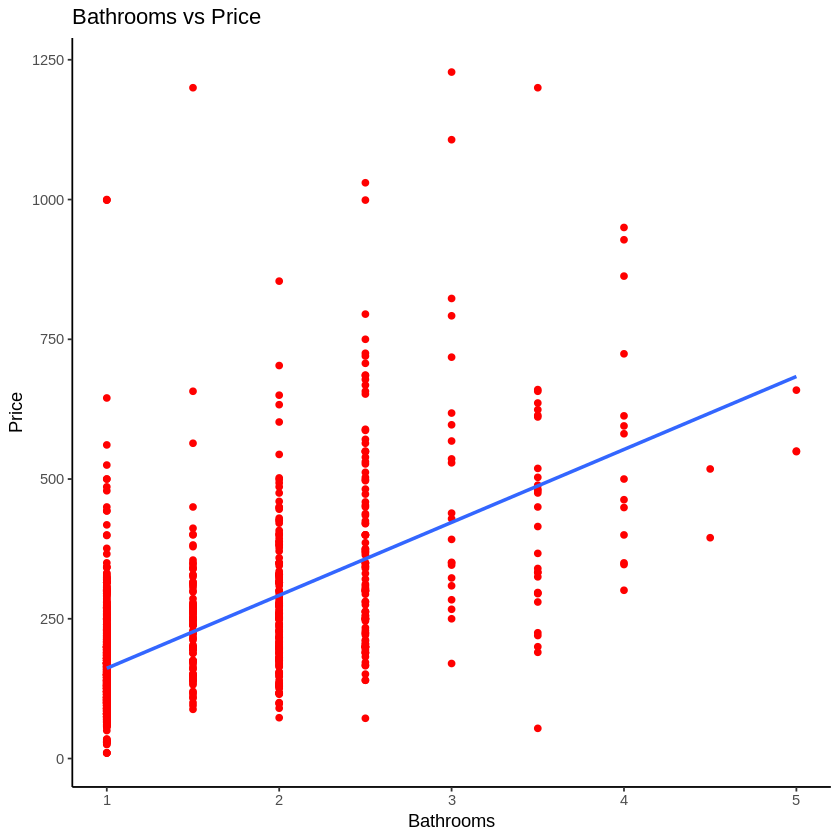

In [108]:
# Visualize Bathrooms vs Price

df %>%
  ggplot(aes(bathrooms, price)) + # Dimensions
  geom_point(color = "red") + # Viz
  geom_smooth(method = "lm", se = FALSE) + # Regression Line
  theme_classic() + # Set theme to remove clutter

  # Set Labels
  labs(x = "Bathrooms",
       y = "Price",
       title = "Bathrooms vs Price")

### 7) Implement a multiple linear regression model for the “price” of the listings. Report the regression coefficients and measures of fit, and write an interpretation of the regression coefficients in the context of this model. Are there any violations of model assumptions?

In [109]:
# Create multiple linear regression model for price of the listings using the top 3 from question 7.
mult_reg = lm(price~bathrooms+accommodates+bedrooms, df)

In [110]:
#Summary of model
summary(mult_reg)


Call:
lm(formula = price ~ bathrooms + accommodates + bedrooms, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-358.80  -50.10  -11.92   33.36  973.72 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     6.205      6.050   1.026 0.305245    
bathrooms      75.808      6.071  12.486  < 2e-16 ***
accommodates   17.452      2.139   8.160 6.42e-16 ***
bedrooms       18.280      5.376   3.401 0.000688 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 103.4 on 1714 degrees of freedom
Multiple R-squared:  0.4337,	Adjusted R-squared:  0.4328 
F-statistic: 437.6 on 3 and 1714 DF,  p-value: < 2.2e-16


**Regression Coefficients**


*   **Intercept:** 6.205 - Not significant with a high p-value (0.31)

*   **Bathrooms:** Each additional bathroom is associated with a $75.81 increase in price.

*   **Accommodates:** Each additional guest accommodated is associated with a $17.42 increase in price.

*   **Bedrooms:** Each additional bedroom is associated with a $18.28 increase in price.






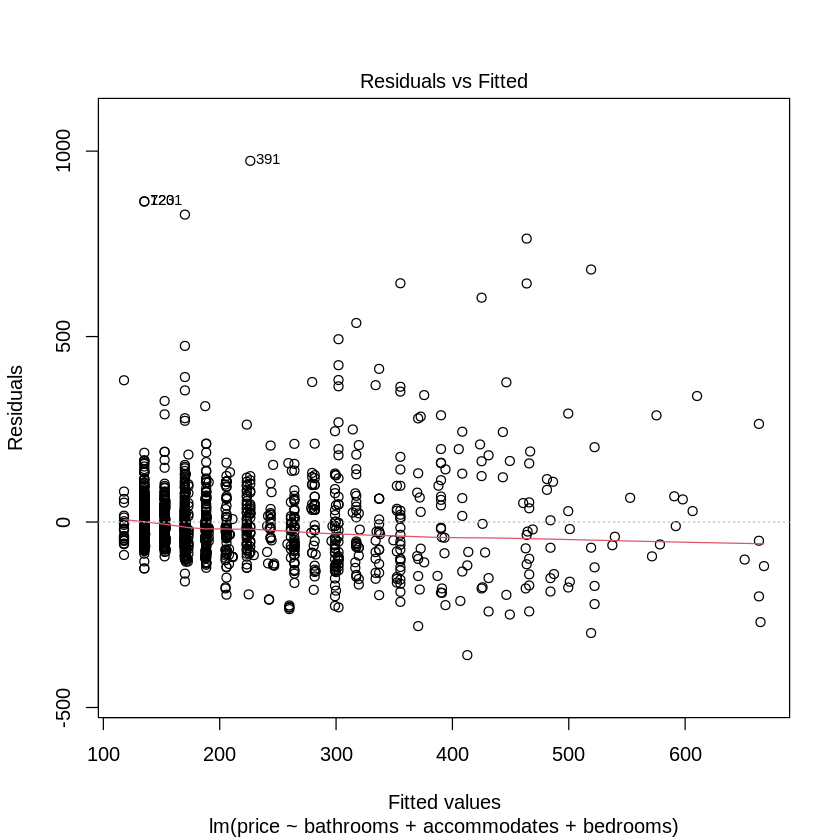

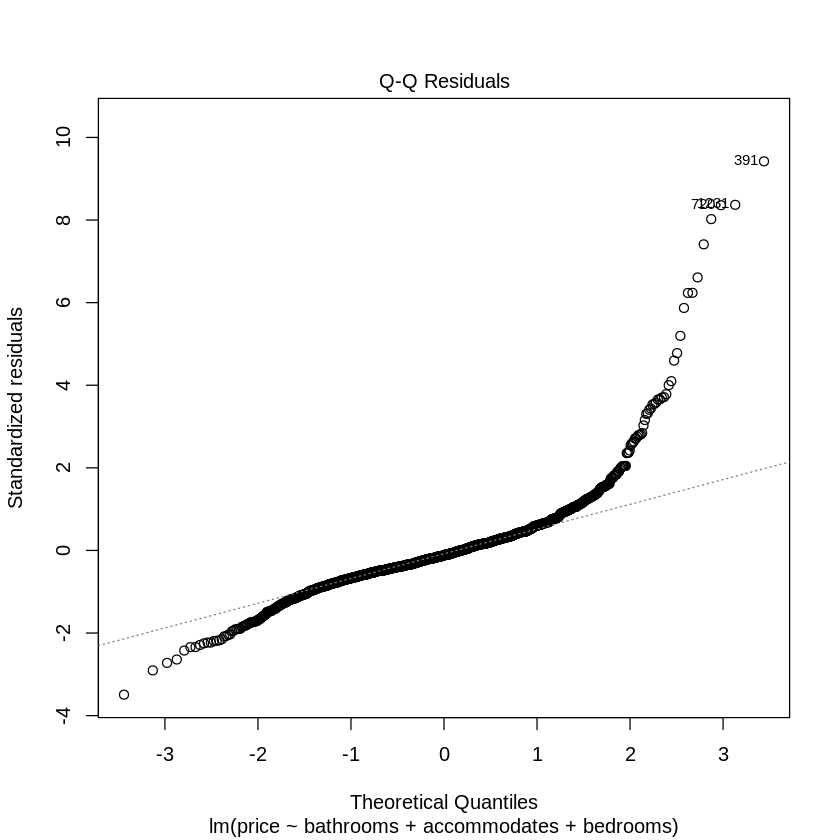

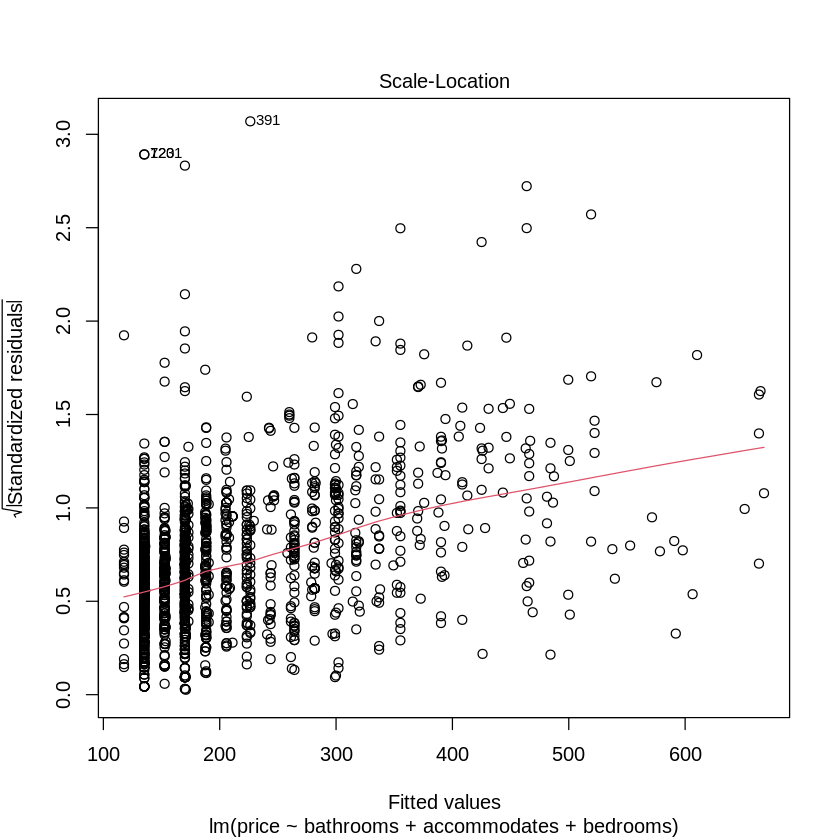

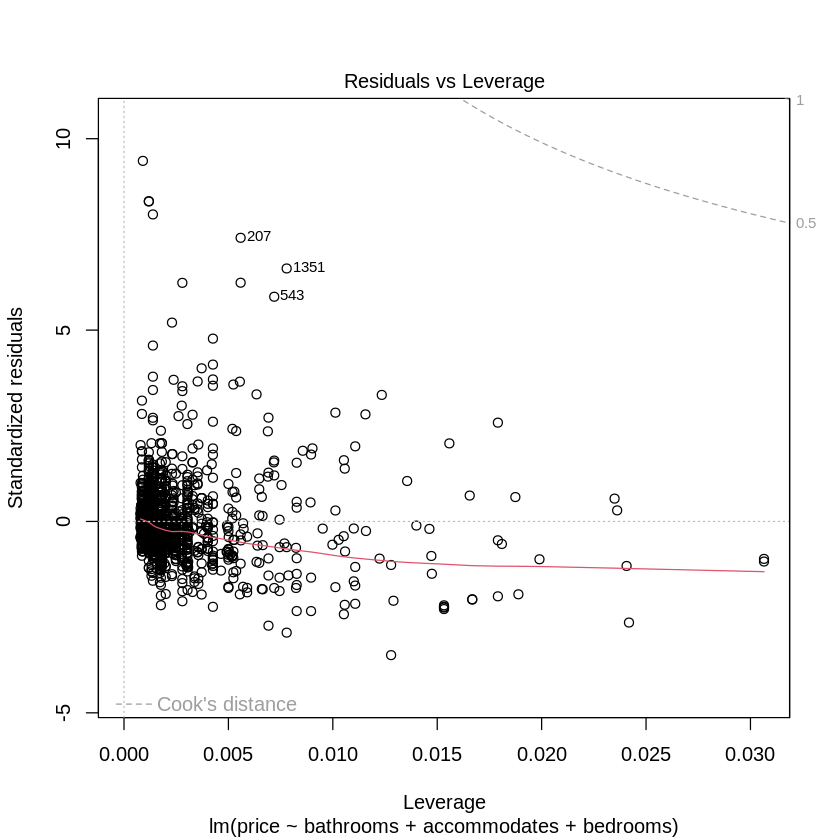

In [111]:
# Diagnostic Plots
plot(mult_reg)

:The diagnostic plots suggest a violation of model assumptions with a non-constant variance.



*   **Residuals vs Fitted** shows a "funnelling", suggesting an increasing variance.

*   **Q-Q Residuals** shows deviations from the normal line. The residuals should remain close to the normal line.

*   **Scale-Location** shows an upward line - meaning a non-constant variance.




### 8) Are there any multicollinearity concerns among the independent variables selected for the multiple regression model of question 7? Explain.

In [112]:
# Create correlation matrix
cor(df[, c("price", "bathrooms", "accommodates", "bedrooms")])

,price,bathrooms,accommodates,bedrooms
price,1.0000000,0.6177192,0.5872468,0.5816707
bathrooms,0.6177192,1.0000000,0.6945863,0.7583391
accommodates,0.5872468,0.6945863,1.0000000,0.7876612
bedrooms,0.5816707,0.7583391,0.7876612,1.0000000


There is multicollinearity among the independent variables, with correlation coefficients ranging from moderate to strong positive. This means a change in one independent variable is associated with changes in another, leading to less reliable inferences in the model.